In [2]:
import scanpy as sc 
import pandas as pd 
import numpy as np 

In [35]:
fov = 244
adata = sc.read_h5ad(f'/ix/djishnu/shared/djishnu_kor11/training_data_2025/human_lymph_cosmx_{fov}.h5ad')
adata

AnnData object with n_obs × n_vars = 5225 × 6175
    obs: 'cell_type', 'cell_type_orig'
    uns: 'cell_type_colors', 'cell_type_orig_colors', 'log1p'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_unscaled'
    varm: 'PCs'
    layers: 'normalized_count', 'raw_count'
    obsp: 'connectivities', 'distances'

In [36]:
tonsil = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/snrna_human_tonsil.h5ad')
tonsil_banksy = pd.read_csv('/ix/djishnu/shared/djishnu_kor11/banksy_outputs/tonsil_banksy_celltypes.csv', index_col=0)
tonsil.obs['banksy_celltype'] = tonsil_banksy.loc[tonsil.obs_names, 'banksy_celltypes'].values
tonsil.obs['banksy_celltype'].value_counts() 

banksy_celltype
T_CD4                   1093
B_memory                 909
GC Light Zone            726
B_naive                  712
GC Dark Zone             560
GC Intermediate Zone     457
T_follicular_helper      334
plasma                   274
mDC/myeloid              240
FDC                      220
T_CD8                    198
pDC                       55
Name: count, dtype: int64

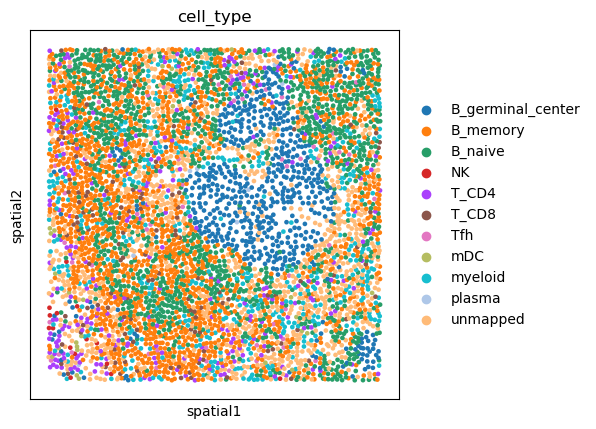

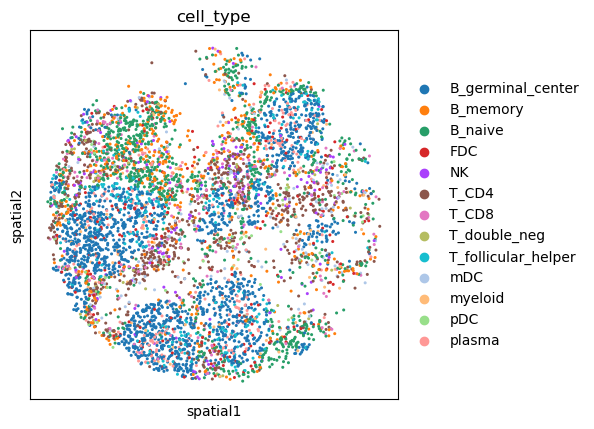

In [37]:
sc.pl.spatial(adata, color='cell_type', spot_size=20)
sc.pl.spatial(tonsil, color='cell_type', spot_size=20)

### Mapping using spatial features

In [38]:
tonsil_cts = tonsil.obs['cell_type'].unique()
adata = adata[adata.obs['cell_type'].isin(tonsil_cts)]
adata

View of AnnData object with n_obs × n_vars = 4340 × 6175
    obs: 'cell_type', 'cell_type_orig'
    uns: 'cell_type_colors', 'cell_type_orig_colors', 'log1p'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_unscaled'
    varm: 'PCs'
    layers: 'normalized_count', 'raw_count'
    obsp: 'connectivities', 'distances'

In [39]:
import sys
sys.path.append('../../src')

In [40]:
from spaceoracle.models.parallel_estimators import create_spatial_features

test_df = create_spatial_features(
    x = adata.obsm['spatial'][:, 0],
    y = adata.obsm['spatial'][:, 1],
    celltypes = adata.obs['cell_type'],
    obs_index= adata.obs.index,
    radius=200
)
test_df.head(3)

B_germinal_center_within  B_memory_within  B_naive_within  \
c_1_244_10                         6.0             81.0             4.0   
c_1_244_100                        0.0             97.0            14.0   
c_1_244_1001                       6.0            157.0            85.0   

              NK_within  T_CD4_within  T_CD8_within  mDC_within  \
c_1_244_10          2.0          16.0           9.0         0.0   
c_1_244_100         0.0          17.0          11.0         0.0   
c_1_244_1001        3.0          24.0          14.0         0.0   

              myeloid_within  plasma_within  
c_1_244_10              16.0            0.0  
c_1_244_100             29.0            0.0  
c_1_244_1001            21.0            0.0

In [41]:
from spaceoracle.models.parallel_estimators import create_spatial_features

ref_df = create_spatial_features(
    x = tonsil.obsm['spatial'][:, 0],
    y = tonsil.obsm['spatial'][:, 1],
    celltypes = tonsil.obs['cell_type'],
    obs_index= tonsil.obs.index,
    radius=200
)
ref_df.head(3)

B_germinal_center_within  B_memory_within  B_naive_within  \
NAME                                                                            
AAACCCAAGCGCCTTG-1                      53.0             18.0            42.0   
AAACCCAAGTGGACGT-1                     156.0             11.0            11.0   
AAACCCACAGAAGTGC-1                     138.0              6.0             4.0   

                    FDC_within  NK_within  T_CD4_within  T_CD8_within  \
NAME                                                                    
AAACCCAAGCGCCTTG-1        11.0       10.0          52.0          18.0   
AAACCCAAGTGGACGT-1        10.0        3.0          16.0           9.0   
AAACCCACAGAAGTGC-1        11.0        5.0          47.0          11.0   

                    T_double_neg_within  T_follicular_helper_within  \
NAME                                                                  
AAACCCAAGCGCCTTG-1                  5.0                        11.0   
AAACCCAAGTGGACGT-1                  0.0                         2.0   
AAACCCACAGAAGTGC-1                  1.0                        15.0   

                    mDC_within  myeloid_within  pDC_within  plasma_within  
NAME                                                                       
AAACCCAAGCGCCTTG-1         8.0             4.0         2.0            5.0  
AAACCCAAGTGGACGT-1         2.0             7.0         3.0           11.0  
AAACCCACAGAAGTGC-1         5.0             5.0         0.0           13.0

In [42]:
ref_df = ref_df.reindex(test_df.columns, axis=1)
ref_df.shape, test_df.shape

((5778, 9), (4340, 9))

In [43]:
test_celltypes = adata.obs['cell_type']
ref_celltypes = tonsil.obs['cell_type']

ref_celltypes.value_counts()

cell_type
B_germinal_center      1848
B_naive                1067
T_CD4                   779
B_memory                516
T_follicular_helper     294
plasma                  262
FDC                     255
T_CD8                   238
NK                      170
mDC                     137
myeloid                 102
pDC                      64
T_double_neg             46
Name: count, dtype: int64

In [44]:
from scipy.stats import spearmanr
# Assuming ref_df, test_df, ref_celltypes, and test_celltypes are already loaded
# ref_celltypes and test_celltypes should be pandas Series or arrays with cell type labels
# with the same indices as ref_df and test_df respectively

# Initialize an empty DataFrame to store the final mapping
final_mapping = pd.DataFrame(index=test_df.index, columns=['reference_cell'])

# Get unique cell types
unique_cell_types = set(ref_celltypes).intersection(set(test_celltypes))

# Process each cell type separately
for cell_type in unique_cell_types:
    # Filter reference and test dataframes by cell type
    ref_indices = ref_df.index[ref_celltypes == cell_type]
    test_indices = test_df.index[test_celltypes == cell_type]
    
    if len(ref_indices) == 0 or len(test_indices) == 0:
        continue
    
    # Filter dataframes
    ref_subset = ref_df.loc[ref_indices]
    test_subset = test_df.loc[test_indices]
    
    # Calculate Spearman correlation within this cell type
    res = spearmanr(ref_subset.values, test_subset.values, axis=1)
    
    # Create correlation DataFrame for this cell type
    corr_df = pd.DataFrame(
        res.statistic[:ref_subset.shape[0], ref_subset.shape[0]:],
        index=ref_subset.index, 
        columns=test_subset.index
    )
    
    corr_df = corr_df.T

    # Find best matches within this cell type
    mapping = corr_df.idxmax(axis=1)
    
    # Update the final mapping for these reference cells
    final_mapping.loc[test_indices, 'reference_cell'] = mapping.values

# Save the mapping to CSV
final_mapping.to_csv(f'mapping_sp_features_ct_{fov}.csv')

print(f"Mapped {final_mapping.count().values[0]} cells out of {len(ref_df)} reference cells")

Mapped 4340 cells out of 5778 reference cells


In [ ]:
# from scipy.stats import spearmanr

# res = spearmanr(ref_df.values, test_df.values, axis=1)

# corr_df = pd.DataFrame(
#     res.statistic[:ref_df.shape[0], ref_df.shape[0]:], 
#     index=ref_df.index, columns=test_df.index
# )

# mapping = corr_df.idxmax(axis=1)
# mapping = pd.DataFrame(mapping, index=corr_df.index)
# mapping.columns = ['reference_cell']

# mapping.to_csv('mapping_sp_features.csv')

### Shared genes only

In [12]:
shared_genes = set(adata.var_names) & set(tonsil.var_names)
shared_genes = list(shared_genes)

adata = adata[:, shared_genes]
tonsil = tonsil[:, shared_genes]

adata, tonsil

(View of AnnData object with n_obs × n_vars = 4354 × 1495
     obs: 'cell_type', 'cell_type_orig'
     uns: 'cell_type_colors', 'cell_type_orig_colors', 'log1p'
     obsm: 'X_pca', 'X_umap', 'spatial'
     varm: 'PCs'
     layers: 'normalized_count', 'raw_count'
     obsp: 'connectivities', 'distances',
 View of AnnData object with n_obs × n_vars = 5778 × 1495
     obs: 'cell_type', 'author_cell_type', 'cell_type_int', 'banksy_celltypes', 'banksy_celltype'
     uns: 'cell_thresholds', 'cell_type_int_colors', 'received_ligands', 'received_ligands_tfl'
     obsm: 'spatial', 'spatial_unscaled'
     layers: 'imputed_count', 'normalized_count')

### Run banksy

In [6]:
import sys
sys.path.append('/ix/djishnu/alw399/SpaceOracle/src/Banksy_py')
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
from banksy_utils.load_data import load_adata, display_adata

In [8]:
raw_x, raw_y = adata.obsm['spatial'][:, 0], adata.obsm['spatial'][:, 1]

In [9]:
from banksy.main import median_dist_to_nearest_neighbour

In [10]:
plot_graph_weights = True
k_geom = 15 # number of spatial neighbours
max_m = 1 # use both mean and AFT
nbr_weight_decay = "scaled_gaussian" # can also choose "reciprocal", "uniform" or "ranked"

# Find median distance to closest neighbours
nbrs = median_dist_to_nearest_neighbour(adata, key = 'spatial')


Median distance to closest cell = 0.005899559305575437

---- Ran median_dist_to_nearest_neighbour in 0.01 s ----



In [11]:
adata.obs['x'] = raw_x
adata.obs['y'] = raw_y

/tmp/ipykernel_20384/3031966821.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['x'] = raw_x



Median distance to closest cell = 0.005899559305575437

---- Ran median_dist_to_nearest_neighbour in 0.01 s ----

---- Ran generate_spatial_distance_graph in 0.02 s ----

---- Ran row_normalize in 0.01 s ----

---- Ran generate_spatial_weights_fixed_nbrs in 0.10 s ----

----- Plotting Edge Histograms for m = 0 -----

Edge weights (distances between cells): median = 0.012518019012606855, mode = 0.014968575757335902

---- Ran plot_edge_histogram in 0.08 s ----


Edge weights (weights between cells): median = 0.05919447637823108, mode = 0.031286976361804796

---- Ran plot_edge_histogram in 0.04 s ----

---- Ran generate_spatial_distance_graph in 0.04 s ----

---- Ran theta_from_spatial_graph in 0.05 s ----

---- Ran row_normalize in 0.01 s ----

---- Ran generate_spatial_weights_fixed_nbrs in 0.27 s ----

----- Plotting Edge Histograms for m = 1 -----

Edge weights (distances between cells): median = 0.017350273773056084, mode = 0.021563752713048456

---- Ran plot_edge_histogram in 0.06 

/ix3/djishnu/alw399/envs/sheep/lib/python3.9/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/ix3/djishnu/alw399/envs/sheep/lib/python3.9/site-packages/numpy/lib/histograms.py:841: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/ix3/djishnu/alw399/envs/sheep/lib/python3.9/site-packages/matplotlib/axes/_axes.py:7004: ComplexWarning: Casting complex values to real discards the imaginary part
  bins = np.array(bins, float)  # causes problems if float16
/ix3/djishnu/alw399/envs/sheep/lib/python3.9/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)



Edge weights (weights between cells): median = (-1.5691558930967664e-09+0.035898102407624734j), mode = -0.011647817133064592

---- Ran plot_edge_histogram in 0.55 s ----

----- Plotting Weights Graph -----
Maximum weight: 0.1857642214798368

---- Ran plot_graph_weights in 1.07 s ----

Maximum weight: (0.08003740930164814-0.01956469980596086j)

---- Ran plot_graph_weights in 2.76 s ----

----- Plotting theta Graph -----


/ix3/djishnu/alw399/envs/sheep/lib/python3.9/site-packages/matplotlib/collections.py:426: ComplexWarning: Casting complex values to real discards the imaginary part
  renderer.draw_path_collection(


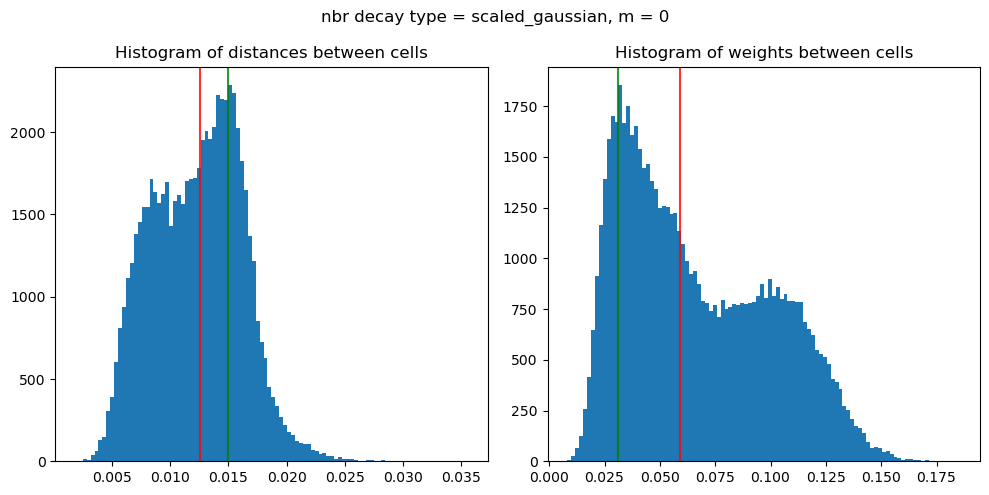

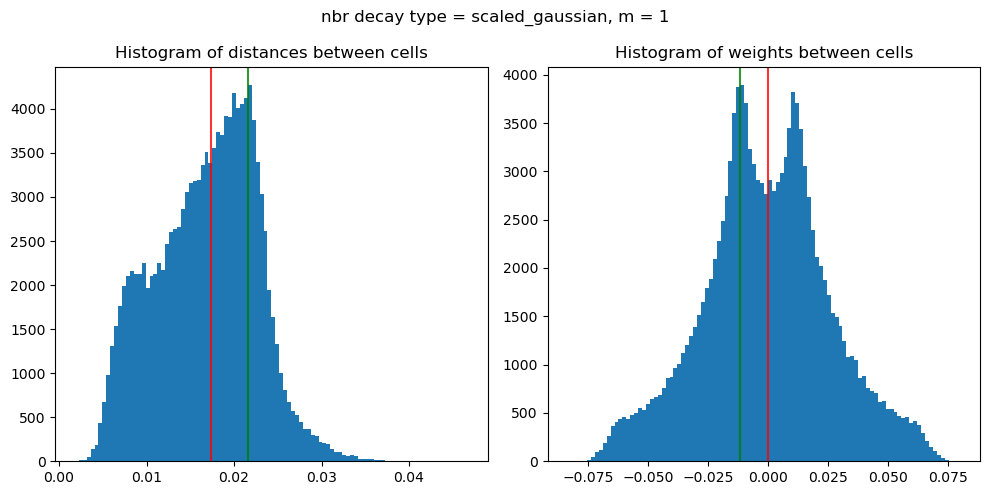

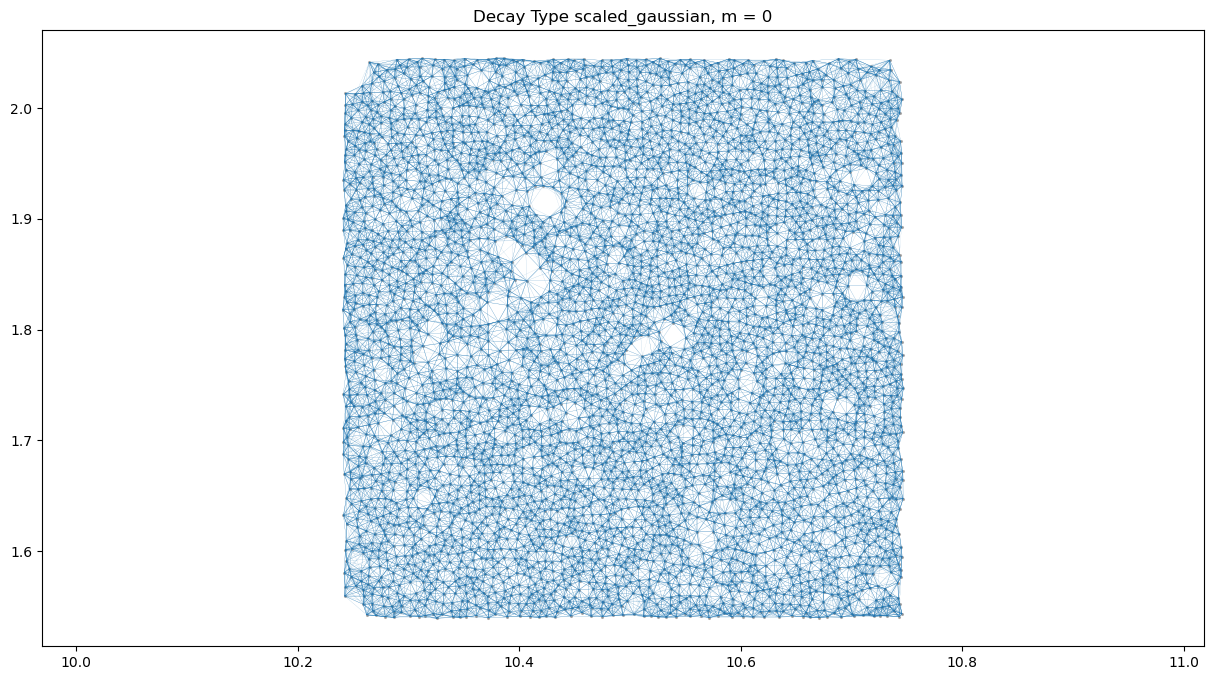

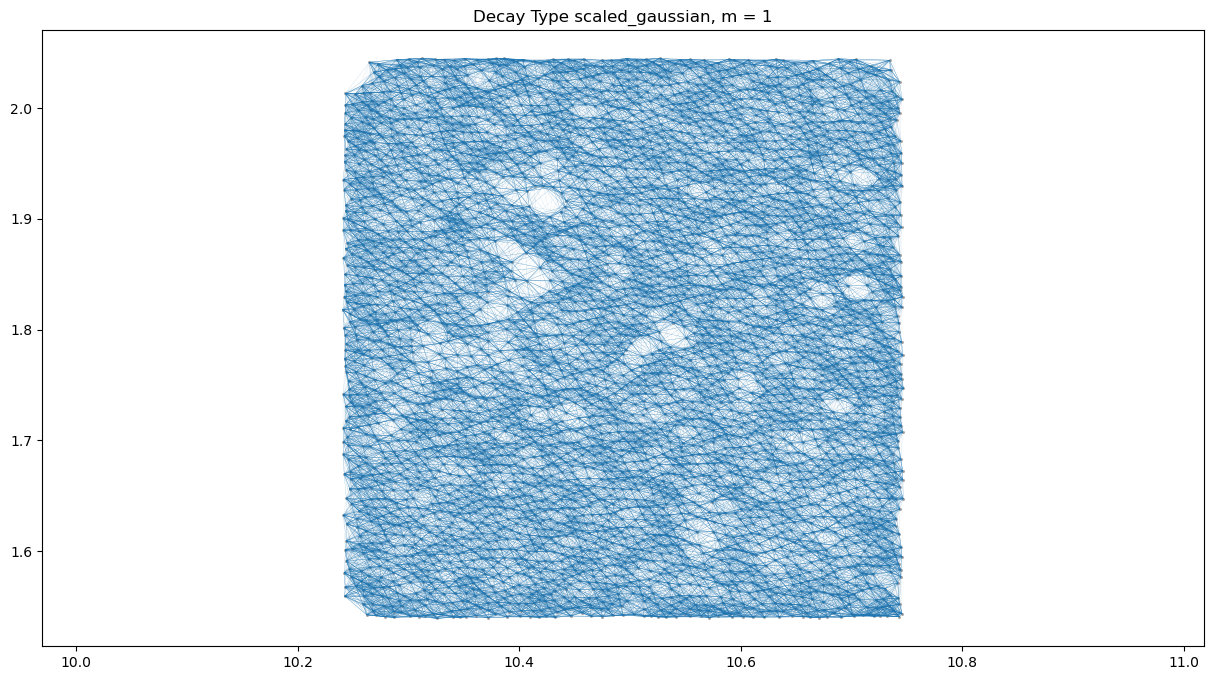

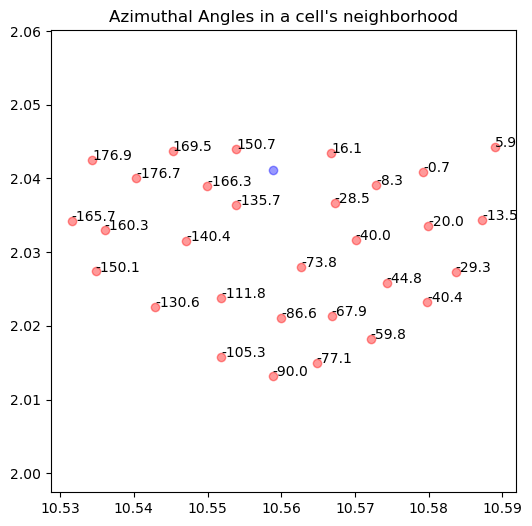

In [12]:
from banksy.initialize_banksy import initialize_banksy

banksy_dict = initialize_banksy(
    adata,
    ('x', 'y', 'spatial'),
    k_geom,
    nbr_weight_decay=nbr_weight_decay,
    max_m=max_m,
    plt_edge_hist=True,
    plt_nbr_weights=True,
    plt_agf_angles=False, # takes long time to plot
    plt_theta=True,
)

In [13]:
from banksy.embed_banksy import generate_banksy_matrix

# The following are the main hyperparameters for BANKSY
# -----------------------------------------------------
resolutions = [0.6]  # clustering resolution for UMAP
pca_dims = [50]  # Dimensionality in which PCA reduces to
lambda_list = [0.2]  # list of lambda parameters

banksy_dict, banksy_matrix = generate_banksy_matrix(adata,
                                                    banksy_dict,
                                                    lambda_list,
                                                    max_m)
banksy_matrix

Runtime May-05-2025-09-46

1495 genes to be analysed:
Gene List:
Index(['CAP1', 'LY6E', 'CACNA1I', 'FGR', 'GAA', 'ULK1', 'TMSB4X', 'ELOVL7',
       'UBA7', 'PIP5K1C',
       ...
       'SV2C', 'ARRB1', 'NTRK3', 'P2RY10', 'TSPAN7', 'SPINK5', 'IL18RAP',
       'HLA-E', 'IL20RB', 'CENPF'],
      dtype='object', length=1495)

Check if X contains only finite (non-NAN) values
Decay Type: scaled_gaussian
Weights Object: {'weights': {0: <4354x4354 sparse matrix of type '<class 'numpy.float64'>'
	with 65310 stored elements in Compressed Sparse Row format>, 1: <4354x4354 sparse matrix of type '<class 'numpy.complex128'>'
	with 130620 stored elements in Compressed Sparse Row format>}}

Nbr matrix | Mean: 0.06 | Std: 0.15
Size of Nbr | Shape: (4354, 1495)
Top 3 entries of Nbr Mat:

[[0.31137674 0.03486508 0.04263067]
 [0.20865281 0.06242124 0.08265311]
 [0.20835001 0.07419645 0.        ]]



AGF matrix | Mean: 0.03 | Std: 0.03
Size of AGF mat (m = 1) | Shape: (4354, 1495)
Top entries of AGF:
[[0.03095775 0.01253188 0.02159467]
 [0.04002997 0.03918781 0.04111403]
 [0.08804892 0.05553996 0.00911642]]
Ran 'Create BANKSY Matrix' in 0.03 mins

Cell by gene matrix has shape (4354, 1495)

Scale factors squared: [0.8        0.13333333 0.06666667]
Scale factors: [0.89442719 0.36514837 0.25819889]
Shape of BANKSY matrix: (4354, 4485)
Type of banksy_matrix: <class 'anndata._core.anndata.AnnData'>



AnnData object with n_obs × n_vars = 4354 × 4485
    obs: 'cell_type', 'cell_type_orig', 'x', 'y'
    var: 'is_nbr', 'k'

In [ ]:
banksy_matrix.to_df().to_parquet('/ix/djishnu/shared/djishnu_kor11/banksy_outputs/human_lymph_cosmx_embedding.parquet')


In [14]:
from banksy.main import concatenate_all

banksy_dict["nonspatial"] = {
    # Here we simply append the nonspatial matrix (adata.X) to obtain the nonspatial clustering results
    0.0: {"adata": concatenate_all([adata.X], 0, adata=adata), }
}

print(banksy_dict['nonspatial'][0.0]['adata'])

Scale factors squared: [1.]
Scale factors: [1.]
AnnData object with n_obs × n_vars = 4354 × 1495
    obs: 'cell_type', 'cell_type_orig', 'x', 'y'
    var: 'is_nbr', 'k'


In [18]:
import gc
gc.collect()

95102

In [ ]:
from banksy_utils.umap_pca import pca_umap

pca_umap(
    banksy_dict,
    pca_dims = pca_dims,
    add_umap = True,
    plt_remaining_var = False,
)

In [ ]:
from banksy.cluster_methods import run_Leiden_partition

results_df, max_num_labels = run_Leiden_partition(
    banksy_dict,
    resolutions,
    num_nn = 50, # k_expr: number of neighbours in expression (BANKSY embedding or non-spatial) space
    num_iterations = -1, # run to convergenece
    partition_seed = 42,
    match_labels = True,
)

In [ ]:
from banksy.plot_banksy import plot_results

c_map =  'tab20' # specify color map
weights_graph =  banksy_dict['scaled_gaussian']['weights'][0]

plot_results(
    results_df,
    weights_graph,
    c_map,
    match_labels = True,
    coord_keys = ('x', 'y', 'spatial'),
    max_num_labels  =  max_num_labels, 
    # save_path = '/tmp',
    save_fig = False
)

In [ ]:
results_df.iloc[0].adata.obs

In [ ]:
label = 'labels_scaled_gaussian_pc50_nc0.20_r0.6'

In [ ]:
adata.obs['banksy_cluster'] = results_df.iloc[0].adata.obs.loc[adata.obs_names][label].copy()

In [48]:
raw_x, raw_y = tonsil.obsm['spatial'][:, 0], tonsil.obsm['spatial'][:, 1]

In [49]:
plot_graph_weights = True
k_geom = 15 # number of spatial neighbours
max_m = 1 # use both mean and AFT
nbr_weight_decay = "scaled_gaussian" # can also choose "reciprocal", "uniform" or "ranked"

# Find median distance to closest neighbours
nbrs = median_dist_to_nearest_neighbour(tonsil, key = 'spatial')


Median distance to closest cell = 9.999999999999794

---- Ran median_dist_to_nearest_neighbour in 0.02 s ----



In [50]:
tonsil.obs['x'] = raw_x
tonsil.obs['y'] = raw_y


Median distance to closest cell = 9.999999999999794

---- Ran median_dist_to_nearest_neighbour in 0.02 s ----

---- Ran generate_spatial_distance_graph in 0.15 s ----

---- Ran row_normalize in 0.02 s ----

---- Ran generate_spatial_weights_fixed_nbrs in 0.31 s ----

----- Plotting Edge Histograms for m = 0 -----

Edge weights (distances between cells): median = 33.81533106908918, mode = 34.58927767314821

---- Ran plot_edge_histogram in 0.08 s ----


Edge weights (weights between cells): median = 0.057726872039865165, mode = 0.041943398344353726

---- Ran plot_edge_histogram in 0.06 s ----

---- Ran generate_spatial_distance_graph in 0.05 s ----

---- Ran theta_from_spatial_graph in 0.05 s ----

---- Ran row_normalize in 0.02 s ----

---- Ran generate_spatial_weights_fixed_nbrs in 0.27 s ----

----- Plotting Edge Histograms for m = 1 -----

Edge weights (distances between cells): median = 48.15919089430059, mode = 52.78642568954706

---- Ran plot_edge_histogram in 0.08 s ----


Edge 

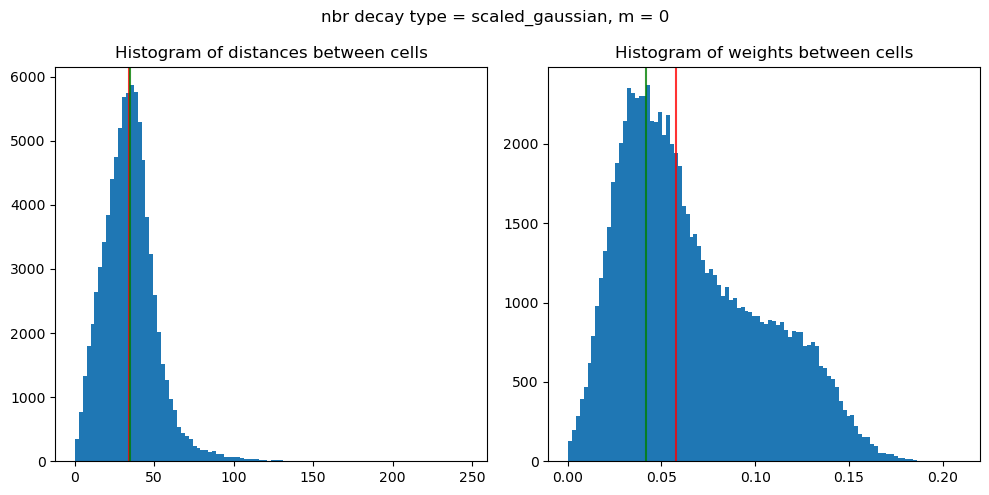

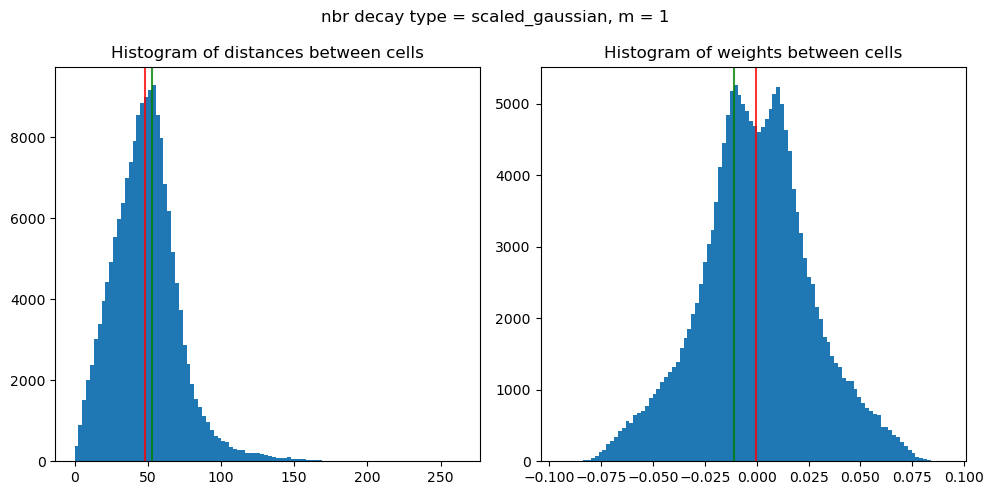

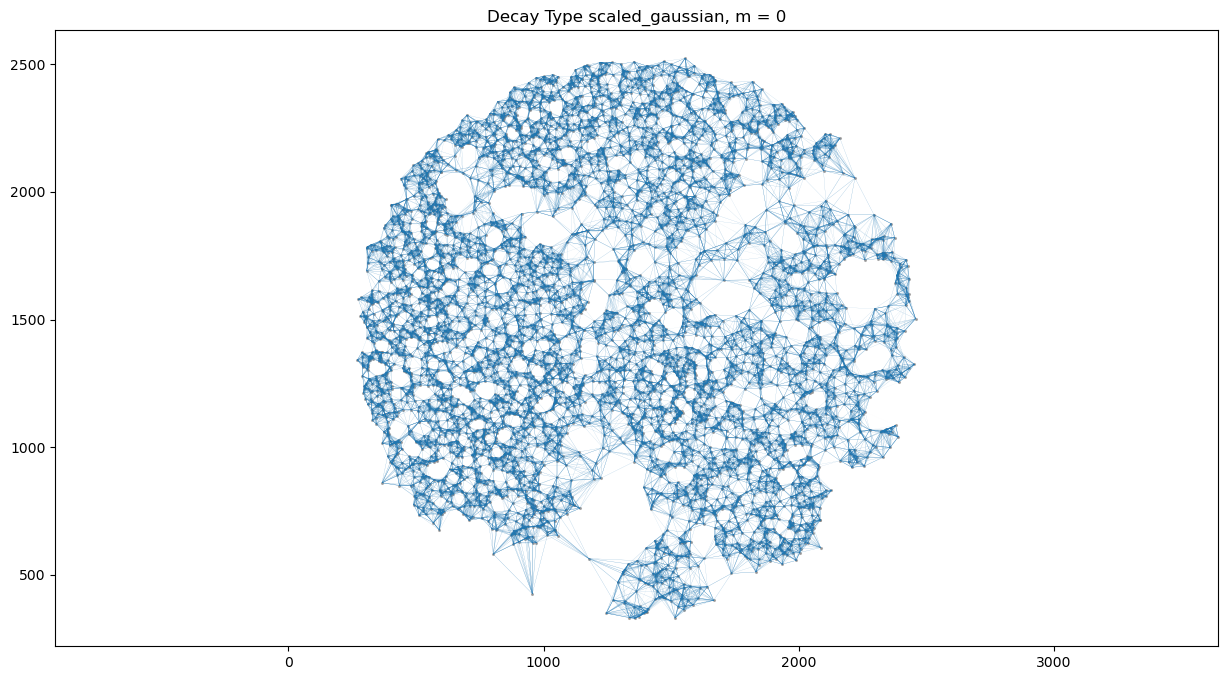

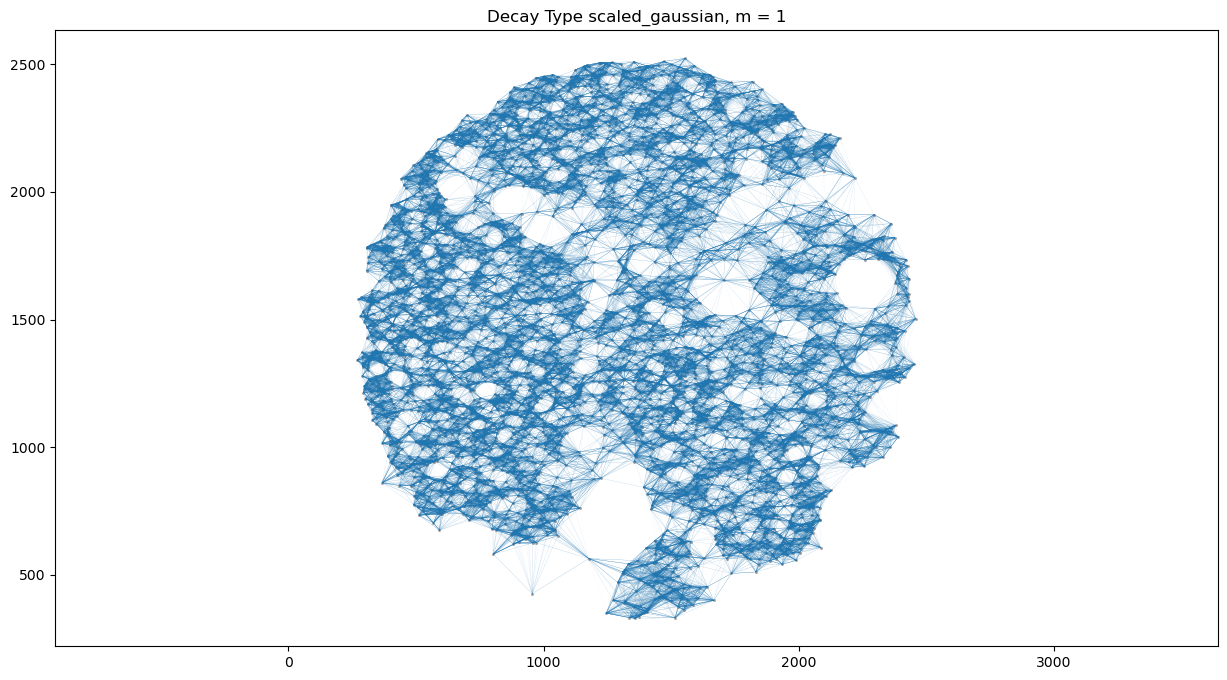

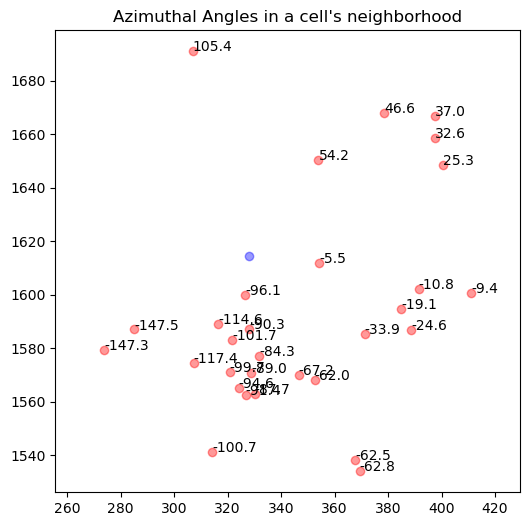

In [51]:
banksy_dict = initialize_banksy(
    tonsil,
    ('x', 'y', 'spatial'),
    k_geom,
    nbr_weight_decay=nbr_weight_decay,
    max_m=max_m,
    plt_edge_hist=True,
    plt_nbr_weights=True,
    plt_agf_angles=False, # takes long time to plot
    plt_theta=True,
)

In [52]:
from banksy.embed_banksy import generate_banksy_matrix

# The following are the main hyperparameters for BANKSY
# -----------------------------------------------------
resolutions = [0.6]  # clustering resolution for UMAP
pca_dims = [50]  # Dimensionality in which PCA reduces to
lambda_list = [0.2]  # list of lambda parameters

banksy_dict, banksy_matrix = generate_banksy_matrix(tonsil,
                                                    banksy_dict,
                                                    lambda_list,
                                                    max_m)
banksy_matrix

Runtime May-02-2025-17-40

1377 genes to be analysed:
Gene List:
Index(['PLK3', 'HLA-G', 'SVIL', 'SASH1', 'CALD1', 'RGPD5', 'NAV3', 'NECTIN3',
       'LGR5', 'TFPI',
       ...
       'TICAM1', 'CTBP2', 'EPHA2', 'IL34', 'DEPTOR', 'LPIN2', 'PXN', 'PRDM16',
       'DSCAML1', 'TSPAN14'],
      dtype='object', name='Unnamed: 0', length=1377)

Decay Type: scaled_gaussian
Weights Object: {'weights': {0: <5778x5778 sparse matrix of type '<class 'numpy.float64'>'
	with 86670 stored elements in Compressed Sparse Row format>, 1: <5778x5778 sparse matrix of type '<class 'numpy.complex128'>'
	with 173340 stored elements in Compressed Sparse Row format>}}

Nbr matrix | Mean: 0.16 | Std: 0.32
Size of Nbr | Shape: (5778, 1377)
Top 3 entries of Nbr Mat:

[[0.10095167 0.         0.23267491]
 [0.         0.         0.        ]
 [0.14304101 0.         0.        ]]

AGF matrix | Mean: 0.06 | Std: 0.08
Size of AGF mat (m = 1) | Shape: (5778, 1377)
Top entries of AGF:
[[0.03008393 0.         0.17142924]
 [0

AnnData object with n_obs × n_vars = 5778 × 4131
    obs: 'cell_type', 'author_cell_type', 'cell_type_int', 'leiden', 'leiden_R', 'cell_type_2', 'banksy_celltype', 'x', 'y'
    var: 'is_nbr', 'k'

In [55]:
banksy_matrix.to_df().to_parquet('/ix/djishnu/shared/djishnu_kor11/banksy_outputs/snrna_human_tonsil_embedding.parquet')


### Mapping

In [13]:
ref_embed = pd.read_parquet('/ix/djishnu/shared/djishnu_kor11/banksy_outputs/snrna_human_tonsil_embedding.parquet')
test_embed = pd.read_parquet('/ix/djishnu/shared/djishnu_kor11/banksy_outputs/human_lymph_cosmx_embedding.parquet')

In [14]:
test_adata = adata.copy()
ref_adata = tonsil.copy()

test_adata, ref_adata

(AnnData object with n_obs × n_vars = 4354 × 1495
     obs: 'cell_type', 'cell_type_orig'
     uns: 'cell_type_colors', 'cell_type_orig_colors', 'log1p'
     obsm: 'X_pca', 'X_umap', 'spatial'
     varm: 'PCs'
     layers: 'normalized_count', 'raw_count'
     obsp: 'connectivities', 'distances',
 AnnData object with n_obs × n_vars = 5778 × 1495
     obs: 'cell_type', 'author_cell_type', 'cell_type_int', 'banksy_celltypes', 'banksy_celltype'
     uns: 'cell_thresholds', 'cell_type_int_colors', 'received_ligands', 'received_ligands_tfl'
     obsm: 'spatial', 'spatial_unscaled'
     layers: 'imputed_count', 'normalized_count')

In [15]:
test_embed = test_embed.reindex(test_adata.obs.index, axis=0)
test_embed = test_embed.reindex(ref_embed.columns, axis=1)

ref_embed = ref_embed.reindex(ref_adata.obs.index, axis=0)

In [16]:
test_adata = sc.AnnData(
    X = test_embed.values,
    obs = test_adata.obs,
    var = pd.DataFrame(index=test_embed.columns),
    obsm = test_adata.obsm
)

ref_adata = sc.AnnData(
    X = ref_embed.values,
    obs = ref_adata.obs,
    var = pd.DataFrame(index=ref_embed.columns),
    obsm = ref_adata.obsm
)

In [17]:
test_adata.X.max(), ref_adata.X.max()

(18.085686232630263, 50.416724574612395)

In [18]:
test_adata.X.min(), ref_adata.X.min()

(-3.445339550635694, -2.9060767831586)

### Batch correct

In [19]:
adata2 = test_adata 
adata1 = ref_adata

adata1, adata2

(AnnData object with n_obs × n_vars = 5778 × 4131
     obs: 'cell_type', 'author_cell_type', 'cell_type_int', 'banksy_celltypes', 'banksy_celltype'
     obsm: 'spatial', 'spatial_unscaled',
 AnnData object with n_obs × n_vars = 4354 × 4131
     obs: 'cell_type', 'cell_type_orig'
     obsm: 'X_pca', 'X_umap', 'spatial')

In [23]:
# sc.tl.pca(adata1)

/tmp/ipykernel_27239/1997364145.py:2: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_concat = adata1.concatenate(adata2)
2025-05-05 10:57:47,925 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-05-05 10:57:49,155 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-05-05 10:57:49,165 - harmonypy - INFO - Iteration 1 of 10
2025-05-05 10:57:49,812 - harmonypy - INFO - Iteration 2 of 10
2025-05-05 10:57:50,458 - harmonypy - INFO - Iteration 3 of 10
2025-05-05 10:57:51,106 - harmonypy - INFO - Iteration 4 of 10
2025-05-05 10:57:51,751 - harmonypy - INFO - Iteration 5 of 10
2025-05-05 10:57:52,394 - harmonypy - INFO - Iteration 6 of 10
2025-05-05 10:57:53,036 - harmonypy - INFO - Converged after 6 iterations


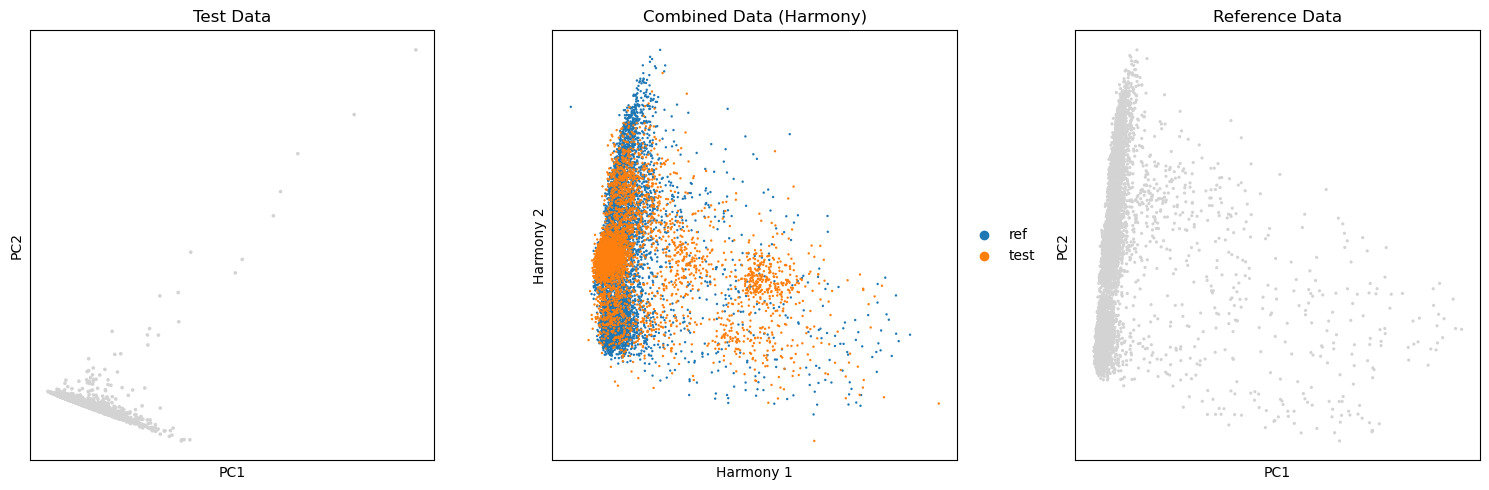

In [24]:
# Concatenate the adatas
adata_concat = adata1.concatenate(adata2)

# Add batch info
adata_concat.obs['batch'] = ['ref' if i < len(adata1) else 'test' for i in range(len(adata_concat))]

# Run PCA
sc.tl.pca(adata_concat)

# Run Harmony
import harmonypy as hp
ho = hp.run_harmony(adata_concat.obsm['X_pca'], adata_concat.obs, ['batch'])
adata_concat.obsm['X_harmony'] = ho.Z_corr.T

# Create figure with 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plot test data
sc.pl.pca(test_adata, show=False, ax=ax1, title='Test Data')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')

# Plot combined data colored by batch
sc.pl.embedding(adata_concat, 'X_harmony', color='batch', show=False, ax=ax2, title='Combined Data (Harmony)')
ax2.set_xlabel('Harmony 1') 
ax2.set_ylabel('Harmony 2')

# Plot reference data
sc.pl.pca(ref_adata, show=False, ax=ax3, title='Reference Data')
ax3.set_xlabel('PC1')
ax3.set_ylabel('PC2')

plt.tight_layout()
plt.show()


In [25]:
pd.DataFrame(
    adata_concat.obsm['X_harmony'], 
    index=adata_concat.obs.index,
    columns=[f'X_harmony_{i}' for i in range(50)]
).to_csv('banksy_subsampled_harmony.csv')

In [26]:
test_adata = sc.AnnData(
    X = adata_concat[test_adata.obs.index + '-1'].obsm['X_harmony'],
    obs = test_adata.obs,
    var = [f'X_harmony_{i}' for i in range(50)],
    obsm = test_adata.obsm
)

ref_adata = sc.AnnData(
    X = adata_concat[ref_adata.obs.index + '-0'].obsm['X_harmony'],
    obs = ref_adata.obs,
    var = [f'X_harmony_{i}' for i in range(50)],
    obsm = ref_adata.obsm
)

In [27]:
# from sklearn.metrics.pairwise import euclidean_distances
# import numpy as np
# import pandas as pd

# # Get the X matrices from both AnnData objects
# test_X = test_adata.X
# ref_X = ref_adata.X

# # Get cell types
# test_cell_types = test_adata.obs['cell_type'].astype(str).values  # Assuming the column is called 'cell_type'
# ref_cell_types = ref_adata.obs['cell_type'].astype(str).values    # Adjust if your column name is different

# # Create a dataframe to store the results
# result_df = pd.DataFrame(index=test_adata.obs.index, columns=['reference_cell'])

# # Calculate distances and find most similar cells for each cell type separately
# for cell_type in np.unique(test_cell_types):
#     # Get indices of cells with this cell type
#     test_indices = np.where(test_cell_types == cell_type)[0]
#     ref_indices = np.where(ref_cell_types == cell_type)[0]
    
#     # Skip if no reference cells of this type
#     if len(ref_indices) == 0:
#         print(f"Warning: No reference cells found for cell type '{cell_type}'. Skipping {len(test_indices)} test cells.")
#         continue
    
#     # Extract the relevant subset of cells
#     test_subset_X = test_X[test_indices]
#     ref_subset_X = ref_X[ref_indices]
    
#     # Calculate distances between cells of this type only
#     distances_subset = euclidean_distances(test_subset_X, ref_subset_X)
    
#     # Find most similar reference cell for each test cell
#     most_similar_subset_indices = np.argmin(distances_subset, axis=1)
    
#     # Map back to the original reference indices
#     most_similar_ref_indices = ref_indices[most_similar_subset_indices]
    
#     # Get the cell IDs
#     test_cell_ids = test_adata.obs.index.values[test_indices]
#     most_similar_cells = ref_adata.obs.index.values[most_similar_ref_indices]
    
#     # Update the result dataframe
#     for i, test_id in enumerate(test_cell_ids):
#         result_df.loc[test_id, 'reference_cell'] = most_similar_cells[i]

# # Add cell type columns for verification
# result_df['test_cell_type'] = pd.Series(test_cell_types, index=test_adata.obs.index)
# result_df['ref_cell_type'] = result_df['reference_cell'].map(
#     pd.Series(ref_cell_types, index=ref_adata.obs.index)
# )

# # Verify that cell types match
# matching = (result_df['test_cell_type'] == result_df['ref_cell_type']).mean()
# print(f"Cell type matching rate: {matching:.2%}")

# # Save to CSV
# result_df.to_csv('mapping_ct.csv')

# print(f"Total test cells: {len(test_adata.obs.index)}")
# print(f"Test cells mapped: {result_df['reference_cell'].notna().sum()}")
# print(f"Test cells not mapped: {result_df['reference_cell'].isna().sum()}")

In [28]:
from sklearn.metrics.pairwise import euclidean_distances

test_X = test_adata.X
ref_X = ref_adata.X

# Calculate pairwise distances between test and reference cells
# This returns a matrix of shape (n_test_cells, n_ref_cells)
distances = euclidean_distances(test_X, ref_X)

# For each test cell, find the index of the reference cell with minimum distance
most_similar_indices = np.argmin(distances, axis=1)

# Get the actual cell IDs from the reference AnnData object
ref_cell_ids = ref_adata.obs.index.values
most_similar_cells = ref_cell_ids[most_similar_indices]

# Create a dataframe with test cell IDs as index and most similar reference cell IDs as values
result_df = pd.DataFrame(
    {'reference_cell': most_similar_cells}, 
    index=test_adata.obs.index
)

result_df.to_csv('mapping.csv')

In [34]:
result_df['test_cell_type'] = result_df.index.map(test_adata.obs['cell_type_orig'])

In [35]:
result_df['ref_cell_type'] = result_df['reference_cell'].map(ref_adata.obs['cell_type'])


In [36]:
result_df.head(3)

reference_cell test_cell_type ref_cell_type
c_1_309_10    CAAGGGATCTCATGGA-1       B cell 1       B_naive
c_1_309_100   TTGAACGGTGCCTGCA-1       B cell 1       B_naive
c_1_309_1000  ACGGTTAAGGTCCGAA-1       B cell 1      B_memory

In [37]:
result_df['test_cell_type'].value_counts()

test_cell_type
B cell 1                       2567
GC B cell                       746
B cell 2                        349
CD4 T cell                      189
pericyte                        135
fibroblast reticular cell 1     118
macrophage                       72
fibroblast reticular cell 2      62
B cell 3                         45
CD8 T cell                       39
plasma cell                      26
APC 1                             6
Name: count, dtype: int64

In [38]:
result_df['ref_cell_type'].value_counts()

ref_cell_type
B_naive                1844
B_germinal_center       609
FDC                     556
B_memory                445
T_CD4                   274
myeloid                 199
T_follicular_helper     198
T_CD8                    69
mDC                      51
plasma                   45
NK                       31
pDC                      21
T_double_neg             12
Name: count, dtype: int64

In [39]:
all_categories = result_df['ref_cell_type'].cat.categories.union(result_df['test_cell_type'].cat.categories)

result_df['ref_cell_type'] = result_df['ref_cell_type'].cat.set_categories(all_categories)
result_df['test_cell_type'] = result_df['test_cell_type'].cat.set_categories(all_categories)

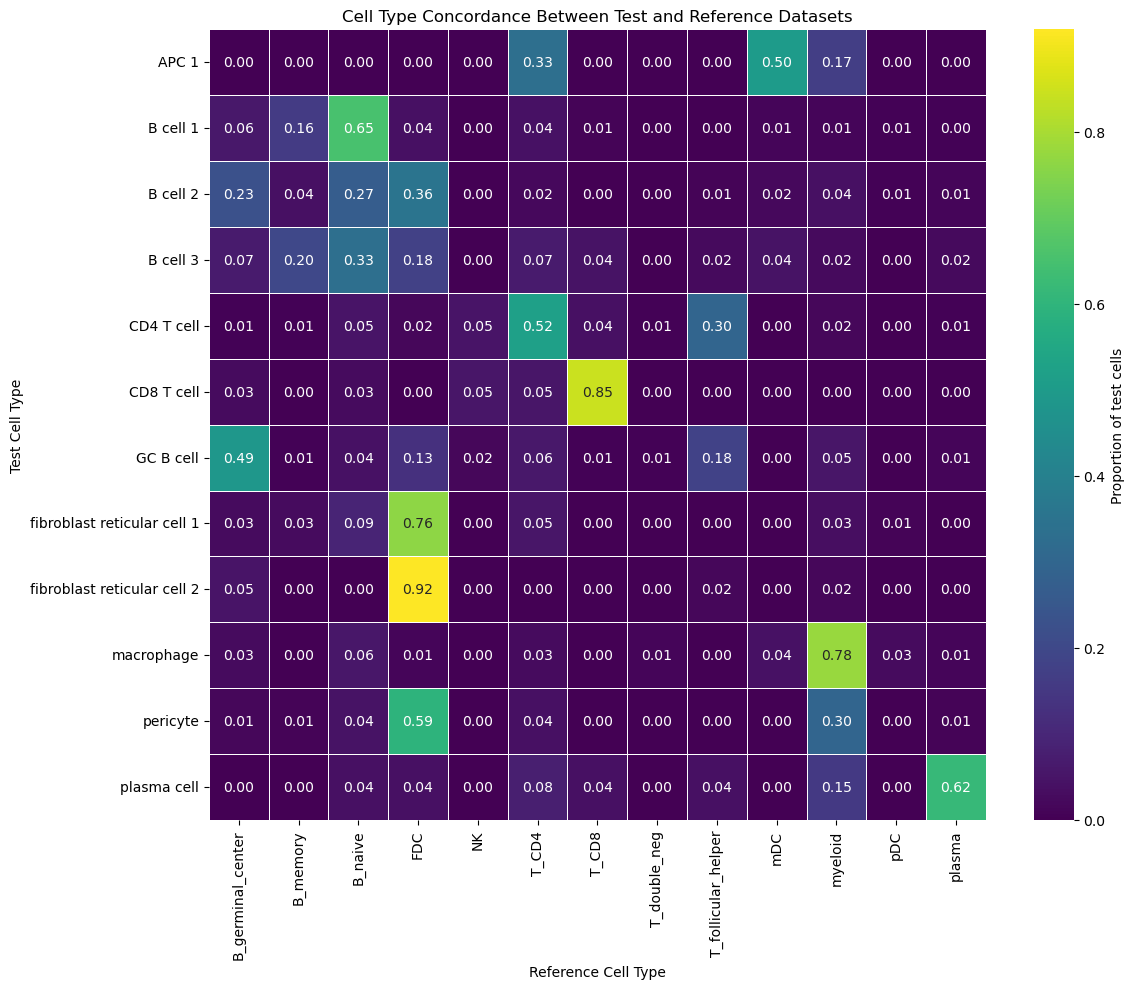

Overall concordance rate: 0.00%

Match distribution:
Matching cell types: 0 cells
Non-matching cell types: 4354 cells

Concordance rate by test cell type:
test_cell_type
APC 1                         0.00%
B cell 1                      0.00%
B cell 2                      0.00%
B cell 3                      0.00%
CD4 T cell                    0.00%
CD8 T cell                    0.00%
GC B cell                     0.00%
fibroblast reticular cell 1   0.00%
fibroblast reticular cell 2   0.00%
macrophage                    0.00%
pericyte                      0.00%
plasma cell                   0.00%
B_germinal_center               NaN
B_memory                        NaN
B_naive                         NaN
FDC                             NaN
NK                              NaN
T_CD4                           NaN
T_CD8                           NaN
T_double_neg                    NaN
T_follicular_helper             NaN
mDC                             NaN
myeloid                         NaN
pD

/tmp/ipykernel_27239/831420756.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  by_cell_type = result_df.groupby('test_cell_type').apply(
/tmp/ipykernel_27239/831420756.py:49: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  by_cell_type = result_df.groupby('test_cell_type').apply(


In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Create a cross-tabulation of the cell types
confusion = pd.crosstab(
    result_df['test_cell_type'], 
    result_df['ref_cell_type'],
    normalize='index'  # Normalize by row (test cell types)
)

# Set up the figure
plt.figure(figsize=(12, 10))

# Create the heatmap
sns.heatmap(
    confusion, 
    annot=True,              # Show values in cells
    cmap='viridis',          # Color scheme
    fmt='.2f',               # Format for cell values (2 decimal places)
    linewidths=0.5,          # Width of cell borders
    cbar_kws={'label': 'Proportion of test cells'}  # Colorbar label
)

# Add labels and title
plt.xlabel('Reference Cell Type')
plt.ylabel('Test Cell Type')
plt.title('Cell Type Concordance Between Test and Reference Datasets')

# Adjust layout for better readability
plt.tight_layout()

# Show the plot
plt.show()

# You can also calculate overall concordance rate
concordance_rate = (result_df['test_cell_type'] == result_df['ref_cell_type']).mean()
print(f"Overall concordance rate: {concordance_rate:.2%}")

# Show distribution of correct/incorrect matches
match_status = (result_df['test_cell_type'] == result_df['ref_cell_type'])
match_counts = match_status.value_counts()
print("\nMatch distribution:")
print(f"Matching cell types: {match_counts.get(True, 0)} cells")
print(f"Non-matching cell types: {match_counts.get(False, 0)} cells")

# Concordance by cell type
by_cell_type = result_df.groupby('test_cell_type').apply(
    lambda x: (x['test_cell_type'] == x['ref_cell_type']).mean()
).sort_values(ascending=False)

print("\nConcordance rate by test cell type:")
print(by_cell_type.to_string(float_format="{:.2%}".format))